# Data Manipulation & Analysis in Python

Now that we have imported data, often we want to use it to determine certain experimental observables. A peak wavelength from a UV/VIS spectra, a lifetime from concentration data, or chemical shift peaks in NMR. There are a multitude of ways to use this data to perform operations, and here we will just present a few.

Let's start with some NMR data of Ag$_2$ZnSnS$_4$ (AZTS) nanocrystals ([Yarur, F. *et al.* (Wilson), **2023.** *ChemRxiv*](https://chemrxiv.org/engage/chemrxiv/article-details/63e465cb3067856f18bc31f3)) labelled `D1 AZTS crude.csv`, using our template from the Importing Data section. Remember though, first we should always just *open up the data* to see what it looks like to figure out how to import it

![image.png](images/nmr_data.png)

What we can notice is that, despite being a .csv file, the data is not comma delimited. In fact, there's just a space between each number. Now we know what parameters to pass to import properly!

ppm =  [-2.0181  -2.01786 -2.01761 ... 14.0179  14.0181  14.0184 ]
signal =  [-0.0377323 -0.0383906 -0.0410056 ...  0.0453818  0.0463226  0.0456263]


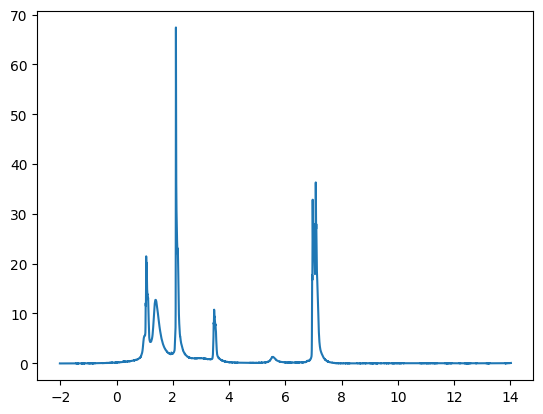

In [2]:
### IMPORT AND ROUGH PLOT DATA
# Import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define where our file can be found to be imported
filepath        = 'data/D1 AZTS crude.csv'

# label each variable something relevant to what it represents
ppm, signal             = np.genfromtxt(filepath,           # string, filepath to data
                                 dtype=float,       # data is float
                                 delimiter='',      # data is separated by spaces/tabs, so leave this blank
                                 skip_header=0,     # when we look, data has no header, so we set this to zero
                                 unpack=True)       # first column is ppm, second column is absorption

# print and plot data to try and look if data imported properly
print('ppm = ',ppm)
print('signal = ',signal)

plt.plot(ppm,signal) # plt.plot(xvalues, yvalues);

Looks like an 1H NMR spectra---but, perhaps backwards!? This is because we did not include in the script any instructions to flip the x-axis left-to-right, which is the usual convention for 1H NMR spectra. We certainly could (and will below---as well as adding *e.g.* axis labels.) However, at this point we're just aiming to see if our data import step worked correctly, and we wanted to make the broader point that it's often wise to start with the simplest possible script to check that a critical step is working, and then build from there.

## Truncating data with boolean logic

`````{admonition} For CHM223 students
:class: important
This subsection is relevant for your assignment!
`````

While we can modify the limits of our plots to highlight specific regions of interest, we also might frequently want to truncate our data itself. For instance, truncation could be helpful if the overall data set is large and unwieldy and we're only interested in a sub-region, or if we're trying to normalize our data to a local extremum instead of an outlier that isn't physically relevant (due to instrumentational limits/flaws, data corruption, etc.)

Luckily, python has easy ways for us to modify our data accordingly using **boolean logic** (For a refresher, check out computational assignment 1.) Given an array of values, we can check each one against a condition, such as being smaller than a certain number. This will return an array of the same size that contains the boolean values of either `True` or `False`. 

Let's use the NMR data above for example. Say we only care about data less than 10 ppm. We can check which values of our `ppm` (x-axis) array correspond to less than 10 ppm as follows:

`print(ppm < 10)`

which returns

`[ True True True True True ...  False False False False False]`

This is useful because we can use this new array of boolean values to modify both of our original arrays, `ppm` (x-axis values) and `signal` (y values). This will keep those elements where the new boolean array has `true`, and discarding those where the condition returned `false`. We could then use these two, truncated arrays to generate another plot. See below:

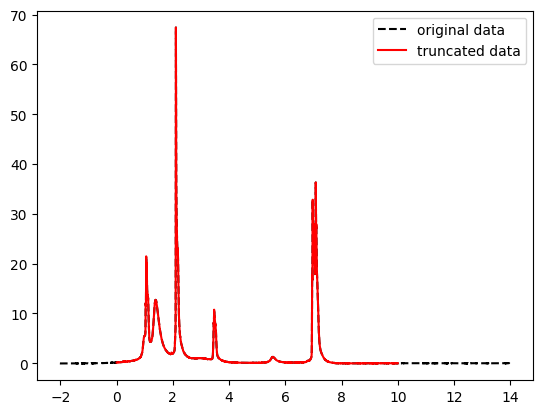

In [3]:
# import data
filepath        = 'data/D1 AZTS crude.csv'
ppm, signal = np.genfromtxt(filepath, dtype=float, delimiter='', skip_header=0, unpack=True)

# plot our data, unmodified
   #As a variation, this time we're going to use the plt.subplots function to generate the figure. This is a python function for plotting with a somewhat-broader scope than plt.plot. For instance (as the name suggests) we could use it to make a single fiure with multiple sub-plots.
fig, ax = plt.subplots() # Generate figure and axes objects
ax.plot(ppm,signal,'--',color='black',label='original data',) #Add an axis with the original data

# modify the ppm and signal arrays to only include values where the signal is less than 10
signal = signal[ppm < 10]   # first, modify the y values to correspond to when the x values are less than 10
ppm = ppm[ppm < 10]         # then, modify the x values to correspond to when the x values are less than 10

# furthermore, we might also want to only include values where ppm is greater than 0
signal = signal[ppm > 0]    # first, modify the y values to correspond to when the x values are greater than 0
ppm = ppm[ppm > 0]          # then, modify the x values to correspond to when the x values are greater than 0

# add our truncated data to the plot
ax.plot(ppm,signal,color='red',label='truncated data') #Add an additional (overlaying) axis with the truncated data

# modify plot appearance
plt.legend() #add the legend
ax.invert_xaxis() # This _flips_ the x-axis left-to-right, which is the usual convention for 1H NMR spectra.
plt.xlabel('$\delta$ ppm') #label the x-axis
plt.ylabel('intensity (arb.)') #label the y-axis

# If we want to, we can also do the same truncation operations for an array of data as above, but with a single line of code
# the & symbol (literally AND) allows us to use Boolean logic and consider multiple comparisons at once. The syntax requires that we put each nested comparison in parentheses. ()
# This time, we'll also generate new arrays for the truncated dataset. We can avoid confusion by giving them obvious variable names.
ppm, signal = np.genfromtxt(filepath, dtype=float, delimiter='', skip_header=0, unpack=True)
truncsignal = signal[(ppm < 10) & (ppm > 0)] # first, modify the y values to correspond to when the x values are less than 10 and greater than 0
truncppm = ppm[(ppm < 10) & (ppm > 0)] # then, modify the x values to correspond to when the x values are less than 10 and greater than 0




## Finding peaks: scipy.find_peaks

`````{admonition} For CHM223 students
:class: important
This subsection is relevant for your assignment!
`````

scipy, like numpy or matplotlib, is another package for python that includes a large number of functions useful for science and data analysis. One of the many included is the function `find_peaks()`, which allows us to locate peaks in an array of values in order to determine their positions, not unlike in commercial FTIR software.

The function is used as follows:

`peaks , _ = scipy.find_peaks(data, height = x, width = y, prominence = z)`

where the newly created array, `peaks`, will contain all the positions (i.e. indices) at which peaks were found in the original `data` array. For example, a value of `34` in one element of the `peaks` array would imply that there is a peak located at `data[34]`. (For those interested, the underscore in `, _` just instructs the computer to throw away all the other things that function returns. We do this here because we're not interested in this other information, but keep in mind that common functions in python have many more capabilities in general than we often need for any particular case!

There are a few important controls for this function, which we can pass to the function as arguments:
- `height =` will specify a threshold for the minimum height of a peak. For instance, if we know the maximum level of our background signal, we can use this setting to avoid flagging incidental maxima that arise from a fluctuating background.
- `width =` will specify the expected width between neighbouring peaks, which can be useful in avoiding identifying multiple sub-peaks on the same overall feature if we expect our data to be separate by more than some number of array elements.
- `prominence =` is a concept from topography is a bit more elusive to define, but is very useful becuase it can directly address (and exclude) shoulders or sub-peaks of a larger feature. In topography, the *prominence* of a peak is its elevation relative to the (highest) valley connecting it to a still-higher peak. Thus, when used in `find_peaks`, this parameter sets *the minimum prominence that a peak must have to be considered a unique peak* (rather than a shoulder of the larger peak). **Often, tailored use of the prominence control alone is sufficient to cleanly identify peaks, so we don't require any others.** This is highlighted in the example below.

 We can see an example of analyzing NMR data below



peaks located at  [1.05098 1.06786 1.38916 2.10859 2.17466 3.46768 5.56162 6.95398 6.97258
 6.9973  7.01516 7.06386 7.08245]


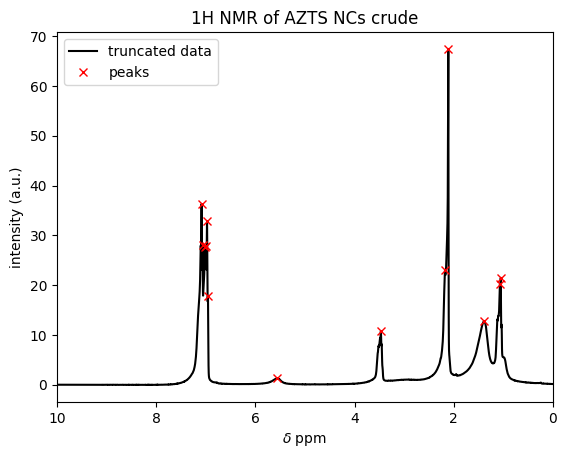

In [4]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import find_peaks

# define where our file can be found to be imported
filepath        = 'data/D1 AZTS crude.csv' # sourced from E:\Dropbox (WilsonLab)\WilsonLab Team Folder\Projects\2021-04 - AZTS (SilKets) NCs\NMR

# import data, using our template from the previous section
ppm, signal            = np.genfromtxt(filepath,
                                 dtype=float,
                                 delimiter='',
                                 skip_header=0,
                                 unpack=True)

# first, truncate our data to our regions of interest

truncsignal = signal[(ppm < 10) & (ppm > 0)] # first, modify the y values to correspond to when the x values are less than 10 and greater than 0
truncppm = ppm[(ppm < 10) & (ppm > 0)]       # then, modify the x values to correspond to when the x values are less than 10 and greater than 0

# plot the data
    #this time, we'll go back to using plt.plot so that you have a more-full example with this syntax
plt.plot(truncppm,truncsignal,color='black',label='truncated data')


# find peaks and plot them
peaks , _ = find_peaks(signal, height=0.1,prominence=1)
plt.plot(ppm[peaks], signal[peaks], "x",label='peaks',color='red')

# Modify plot appearance
plt.xlim(10,0) # flip the x-axis left-to-right to adopt the conventional style for NMR plots
plt.xlabel('$\delta$ ppm')
plt.ylabel('intensity (arb.)')
plt.title('1H NMR of AZTS NCs crude') # change title to match sample name
plt.legend() # show a legend with the labels we defined earlier
print('peaks located at ',ppm[peaks]) # print the ppm values of the peaks



## Background subtraction

A very common correction you will need to do to experimental data is background subtraction. Some commercial software does this automatically, and only outputs the result. However other software/instruments first record a blank/background measurement, then record the data from your sample(s). This is often preferable in more-exploratory or demanding measurements, so that you can review the results of both measurment and perform the subtraction with care (either manually, or via a workflow.)

Sometimes background subtraction can be as simple as subtracting a constant amount from all your data. Returning to our fluorescence spectra example from the Importing Data page (which you can also see in the plot below as the red 'raw' trace), we see that there is a flat, positive signal that persists outside of the range of wavelengths where we would expect photoluminescence (mainly, <300 nm and >900 nm. In practice this signal arises from read noise and detector dark counts, and so does not reflect *real* fluorescence.) To address this, we would determine what is the average value of this background---lets say we do this and call the result `bg`. Then, we could subtract `bg` from *every* element in our intensity array (because such a background would add to the signal *everywhere*, even in spectral regions where we did detect light!). We can subtract a constant from every element of an array using the following manipulation:

`intens = intens - bg`

All this does is take every element of the `array` we defined as `intensity`, and subtract the value `bg` from it (which could be a number, e.g. 1565.) As an example, lets do this with the data we imported in the **Importing Data** module

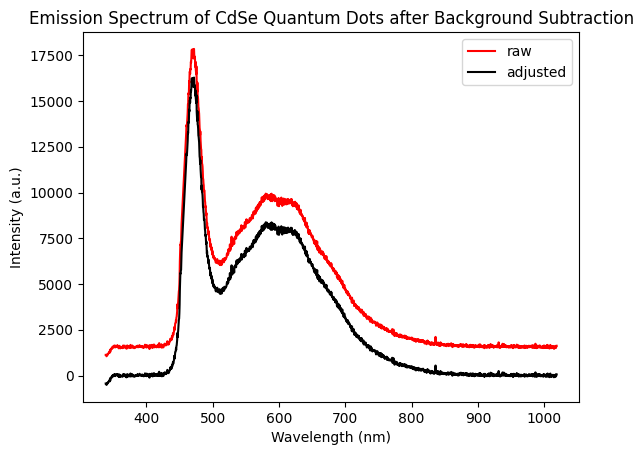

In [5]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define where our file can be found to be imported
filepath        = 'data/CdSe_EmissionSpectra.txt'

wavelengths, intensities   = np.genfromtxt(filepath,
                                 dtype=float,
                                 delimiter='',
                                 skip_header=14,
                                 unpack=True)

# plot the raw data

plt.plot(wavelengths,intensities,color='red',label='Raw Data') # plt.plot(xvalues, yvalues)

# estimate background by averaging the values in intensity that are beyond 900nm
indexVal = np.argmax(wavelengths>900) # finds the index of the first element in the `wavelengths` array that is greater than 900nm. We can then use this index to refer to data in the matched `intensities` array.
bg = np.average(intensities[indexVal:-1]) # finds the average value of the elements in the intensities array between indexVal and the last element in the array (which we can always refer to in python by the index `-1`)
bkSubIntensities = intensities - bg     # subtract background

plt.plot(wavelengths,bkSubIntensities,color='black',label='Background-Subtracted')
#plt.xlim(400,900) #We could un-comment this to restrict the range of wavelengths that appear in the plot, if we wished.
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (arb.)')
plt.title('Emission Spectra of CdSe Quantum Dots: Before/after normalization')
plt.legend()


## Normalization 
Another common practice when working with many types of data is *normalization*, where we wish to scale the data so that its maximum value is unity (i.e. `1`). This is especially the case when the absolute readings of an instrument don't have special meaning (calibration can be challenging!), or if you want to compare the shape (rather than the magnitude) of a series of distinct measurements.

Given some array, for example the `itensities` array from the previous example with a fluorescence spectrum, simple normalization can be achieved in one line:
`normIntensities = intensities/max(intensities)`

You can see how this works conceptually, the `max()` function returns the greatest value in the `intensities` array. We then divide (each element of) the array by this number, and store the result in `normIntensities`.

However, often we will only be interested in determining a local maximum to normalize to. (For instance, if there are large signals elsewhere in the array that we're not interested in, perhaps because they arise from a different physical process, or instrumental noise.) Here, we can utilize truncation as described above to cause the `max` function to look for a maximum in a specified range.

To highlight this in action, let's look at some **UV-VIS absorption data** and see the before and after plots.

Text(0.5, 1.0, 'absorption data pre manipulation')

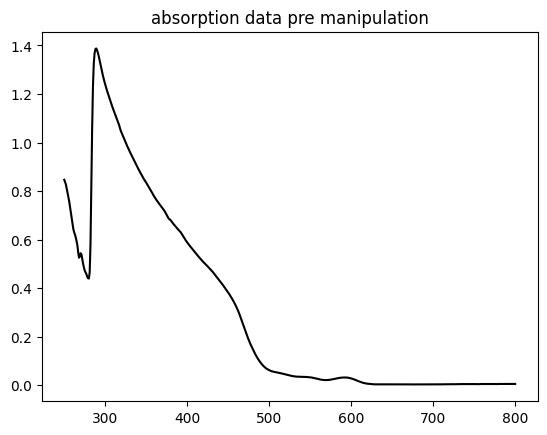

In [6]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define where our file can be found to be imported
filepath        = 'data/2020-02-11 ITK605 Absorption.csv'

x, y            = np.genfromtxt(filepath,
                                 dtype=float,
                                 delimiter=',',
                                 skip_header=2,
                                 unpack=True)

# plot raw data
plt.plot(x,y,color='black')
plt.title("absorption data pre manipulation")

We can see from the figure above that the raw data is not incredibly useful, however with some simple manipulation we can make it much more fruitful. The instrument often has artifacts that we have to account for or exclude when analyzing data. Let's see below what some simple manipulation can do!

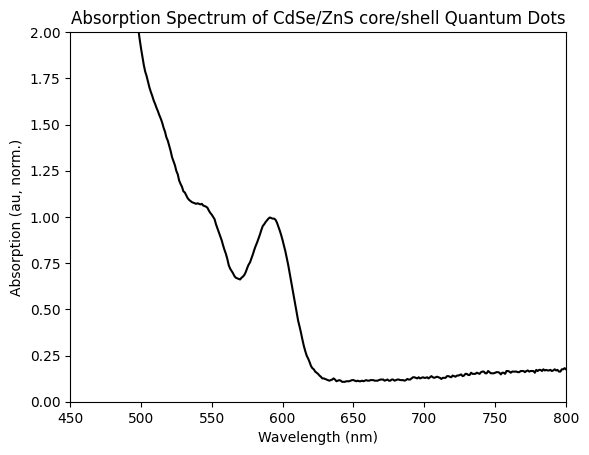

In [7]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define where our file can be found to be imported
filepath        = 'data/2020-02-11 ITK605 Absorption.csv'

x, y            = np.genfromtxt(filepath,
                                 dtype=float,
                                 delimiter=',',
                                 skip_header=2,
                                 unpack=True)

# first, truncate my data to 450 nm and beyond
y = y[x > 450] # first, modify the y values to corruspond to when the x values are greater than 450
x = x[x > 450] # then, modify the x values to corruspond to when the x values are greater than 450

# next, locate the local maximum that I know is around 600 nm
local_y = y[(x > 550) & (x < 650)] # truncate y values to x values between 600 and 610
local_max = max(local_y) # find global maximum

# normalize by local maximum
y = y/local_max

# plot normalized data
plt.plot(x,y,color='black',label='normalized')

# we can also subtract the background, however we usually do that before normalizing and wont do it here

# set plot labels and title
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption (au, norm.)')
plt.title('Absorption Spectrum of CdSe/ZnS core/shell Quantum Dots')
# set x and y limits
plt.xlim(450,800)
plt.ylim(0,2);

This is especially useful when comparing distinct spectra, such as in the case where we need to import multiple files.

## Flipping data

Sometimes, the order in which instruments record data is not necessarily how we want to plot it or analyze it. For example, let's say we want to plot the emission by energy rather than wavelength. For reference, we can convert from wavelength of emission to energy in electronvolts by the following:

$$
E_{\lambda} = \frac{1239.8}{\lambda}  \text{ eV}
$$

So we can easily plot emission intensity versus energy as follows:

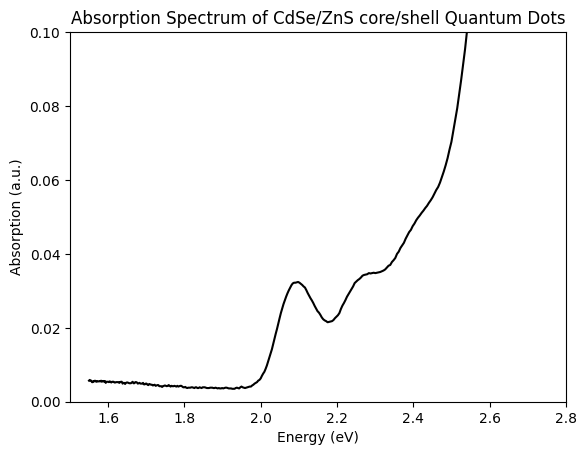

In [8]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define where our file can be found to be imported
filepath        = 'data/2020-02-11 ITK605 Absorption.csv'

x, y            = np.genfromtxt(filepath,
                                 dtype=float,
                                 delimiter=',',
                                 skip_header=2,
                                 unpack=True)

# plot raw data

# calculate a new energy array from wavelength array
ev = 1239.8/x

# plot raw data by ev instead of wavelength
plt.plot(ev,y,color='black')

# we can also subtract the background, however we usually do that before normalizing and wont do it here

plt.xlabel('Energy (eV)')
plt.ylabel('Absorption (a.u.)')
plt.title('Absorption Spectrum of CdSe/ZnS core/shell Quantum Dots')

# set axis limits
plt.xlim(1.5,2.8)
plt.ylim(0,0.1);

Generally we plot energy from highest to lowest, however by default `matplotlib` plots from lowest to highest values. This is common for many other plots, such as NMR plots which we will see later below. We can easily fix this by reversing the order of our axis limits to `plt.xlim(max,min)` rather than the typical min, max order. We can easily obtain the minimum and maximum values for our x-axis by calling `max(x)` and `min(x)` respectively, where `x` is whatever label we use for our x-data. See below for example

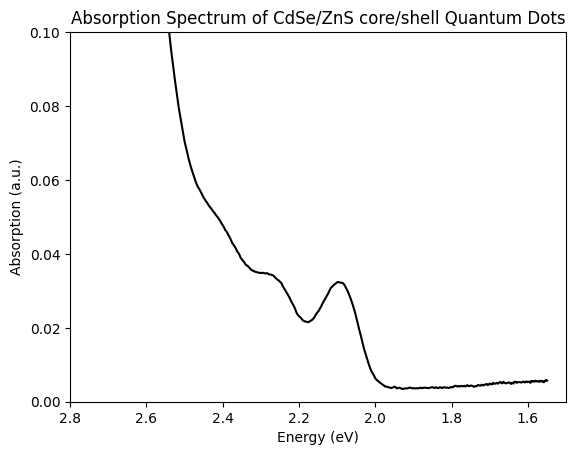

In [9]:
# plot data
plt.plot(ev,y,color='black')

# reverse x-axis, to go in descending order. Often used when plotting quantities related to energy.
plt.xlim(max(ev),min(ev))
# or, if we want to specify the limits in terms of energy
plt.xlim(2.8,1.5)

plt.ylim(0,0.1)

plt.xlabel('Energy (eV)')
plt.ylabel('Absorption (a.u.)')
plt.title('Absorption Spectrum of CdSe/ZnS core/shell Quantum Dots');

Additionally, We also may want to do this with our data arrays themselves. To do this, we can simply use `np.flip` as below on our UV-VIS data for example

In [10]:
print('original array:',ev[0:10])
ev_flipped = np.flip(ev)
print('flipped array:',ev_flipped[0:10])

original array: [1.54975    1.55168961 1.55363409 1.55558344 1.55753769 1.55949686
 1.56146096 1.56343001 1.56540404 1.56738306]
flipped array: [4.9592     4.93944223 4.91984127 4.90039526 4.88110236 4.86196078
 4.84296875 4.82412451 4.80542636 4.78687259]


This is useful in case we want to work with our data in a specific order of values! But usually, just reversing the plot will be enough.